# Data Exploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("NQ_from_2000.csv", sep= ";")

In [3]:
df.head()

,Date,Time,Open,High,Low,Close,Up,Down,PLOT1,PLOT2
0,01/03/2000,01:00,6975.5,6977.0,6975.5,6975.5,3,0,0.0,0.0
1,01/03/2000,02:00,6977.5,6979.5,6977.5,6979.5,2,0,-1.0,-1.0
2,01/03/2000,03:00,6979.5,6993.5,6979.5,6987.5,21,0,-1.0,-1.0
3,01/03/2000,04:00,6986.5,6994.5,6984.5,6992.5,16,0,-1.0,-1.0
4,01/03/2000,05:00,6994.5,6999.5,6993.5,6999.5,19,0,-1.0,-1.0


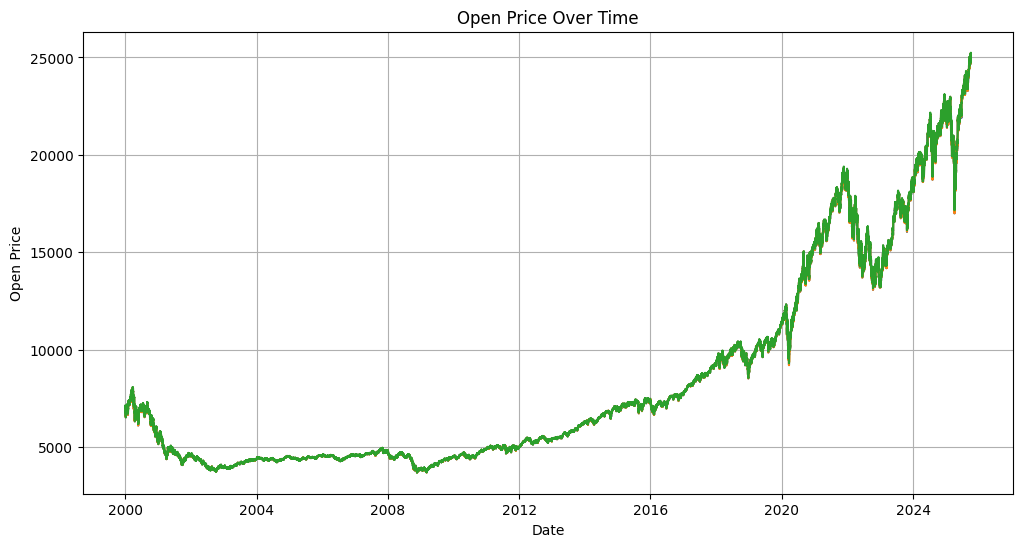

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Open'])
plt.plot(df['Date'], df['Close'])
plt.plot(df['Date'], df['High'])
plt.title('Open Price Over Time')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.grid(True)
plt.show()

In [5]:
High_low_delta = np.mean(df["High"] - df["Low"])
High_low_delta

np.float64(20.215157563803075)

In [6]:
High_low_delta = np.mean(df["Open"] - df["Close"])
High_low_delta 

np.float64(-0.12723588455867998)

# Quant Strategies

## Hypothesis

We assume
- Instant trade
- No fees on trades
- We can buy any percentage of the index fund
- No impact on market
- No arbitrage
- Unlimited Capital


## 1.Benchmark

Time in the market beats timing in the market 

The benchmark buys 100 $ of the index fund each first of the month at 12

In [8]:
# Filter data
benchmark_trades = df[(df['Time'] == '12:00') & (df['Date'].dt.day == 1)]

# Compute the performance
investment = 0
units = 0

for _, trade in benchmark_trades.iterrows():
    # Buy 100 dollar worth at the open price
    units += 100 / trade["Open"] 
    investment +=  100
    
# Compute final value using the last close price
final_value = units * df['Close'].iloc[-1]
total_return = (final_value - investment) / investment * 100
PnL = (final_value - investment)

print(f"Total investment: ${investment:,.2f}")

print(f"Final value: ${final_value:,.2f}")
print(f"PnL : ${PnL:,.2f}")
print(f"Total return: {total_return:.2f}%")

Total investment: $19,900.00
Final value: $78,233.12
PnL : $58,333.12
Total return: 293.13%


## 2. Systematic strategy

Very basic momentum based strat 

- If for 3 consecutive hours the price rises by more than the average High-Low delta, we buy $100
- If for 5 consecutive hours price falls by more than the average High-Low delta, we sell $100

I think I saw this in an insta reel about Citadelle

In [9]:
# Initialize variables
investment = 0
units = 0
consecutive_up = 0
consecutive_down = 0
volume =0

# Iterate through data
for i in range(1, len(df)):
    price_change = df['Close'].iloc[i] - df['Close'].iloc[i-1]
    High_low_delta = df['High'].iloc[i-1] - df['Low'].iloc[i-1]

    # Check for upward momentum
    if price_change > High_low_delta:
        consecutive_up += 1
        consecutive_down = 0
    # Check for downward momentum
    elif price_change < -High_low_delta:
        consecutive_down += 1
        consecutive_up = 0
    else:
        consecutive_up = 0
        consecutive_down = 0
    
    # Buy condition: 3 consecutive up hours
    if consecutive_up >= 3:
        units += 100 / df['Close'].iloc[i]
        volume += 100
        investment += 100
        consecutive_up = 0
    
    # Sell condition: 5 consecutive down hours
    if consecutive_down >= 5 and units > 0:
        sell_amount = min(100, units * df['Close'].iloc[i])
        units -= sell_amount / df['Close'].iloc[i]
        investment -= sell_amount
        consecutive_down = 0

# Calculate final results
final_value = units * df['Close'].iloc[-1]
total_return = (final_value - investment) / investment * 100 if investment != 0 else 0
PnL = final_value - investment

print(f"Total Volume: ${volume:,.2f}")
print(f"Total investment: ${investment:,.2f}")
print(f"Final value: ${final_value:,.2f}")
print(f"PnL: ${PnL:,.2f}")
print(f"Total return: {total_return:.2f}%")

Total Volume: $2,100.00
Total investment: $2,100.00
Final value: $9,643.65
PnL: $7,543.65
Total return: 359.22%


Let's try this strat but over the past month only

In [10]:
# Initialize variables

month_df = df[df["Time"] >= "15/09/2025"]

investment = 0
units = 0
consecutive_up = 0
consecutive_down = 0
volume = 0

# Iterate through data (use month_df)
for i in range(1, len(month_df)):
    price_change = month_df['Close'].iloc[i] - month_df['Close'].iloc[i-1]
    High_low_delta = month_df['High'].iloc[i-1] - month_df['Low'].iloc[i-1]

    # Check for upward momentum
    if price_change > High_low_delta:
        consecutive_up += 1
        consecutive_down = 0
    # Check for downward momentum
    elif price_change < -High_low_delta:
        consecutive_down += 1
        consecutive_up = 0
    else:
        consecutive_up = 0
        consecutive_down = 0
    
    # Buy condition: 3 consecutive up hours
    if consecutive_up >= 3:
        units += 100 / month_df['Close'].iloc[i]
        investment += 100
        consecutive_up = 0
    
    # Sell condition: 5 consecutive down hours
    if consecutive_down >= 5 and units > 0:
        sell_amount = min(100, units * month_df['Close'].iloc[i])
        units -= sell_amount / month_df['Close'].iloc[i]
        investment -= sell_amount
        volume += 100
        consecutive_down = 0

# Calculate final results using month_df
final_value = units * month_df['Close'].iloc[-1]
total_return = (final_value - investment) / investment * 100 if investment != 0 else 0
PnL = final_value - investment

print(f"Total Volume: ${volume:,.2f}")
print(f"Total investment: ${investment:,.2f}")
print(f"Final value: ${final_value:,.2f}")
print(f"PnL: ${PnL:,.2f}")
print(f"Total return: {total_return:.2f}%")

Total Volume: $0.00
Total investment: $900.00
Final value: $4,047.51
PnL: $3,147.51
Total return: 349.72%


Surprisingly it works 

However ! Relatively no trades were made and we didn't sell anything 
So I think this would work better in a HFT 

## 3 Machine Learning 

### A. Feature engineering

In [7]:
from utils.feature_engineering import feature_engineering
df_ML = df.copy()
df_ML = feature_engineering(df_ML)

df_ML = df_ML[df_ML["Date"] >= "01/01/2002"] #to get all the rollings ok

In [7]:
df_ML.head()

,Date,Time,Open,rolling_1Y,rolling_90d,rolling_30d,rolling_14d,rolling_7d,rolling_1d,rolling_12h,rolling_3h,vol,vol_rolling,vol_last_day,return_1h,return_24h
8971,2002-01-02,06:00,4529.0,5600.370719,4440.321296,4564.401389,4592.791667,4564.208333,4569.479167,4563.250000,4539.000000,14.5,6.250000,63.5,-0.001213,-0.011567
8972,2002-01-02,07:00,4538.0,5600.076256,4440.232639,4564.503472,4592.565476,4563.776786,4567.875000,4560.041667,4533.833333,13.0,6.479167,63.5,0.001987,-0.008413
8973,2002-01-02,08:00,4538.0,5599.780537,4440.143981,4564.587500,4592.337798,4563.315476,4566.208333,4557.083333,4535.000000,7.0,6.416667,62.0,0.000000,-0.008737
8974,2002-01-02,09:00,4544.5,5599.487158,4440.067130,4564.689583,4592.072917,4562.928571,4564.875000,4554.541667,4540.166667,9.5,6.666667,62.0,0.001432,-0.006992
8975,2002-01-02,10:00,4533.5,5599.190468,4439.992361,4564.760417,4591.730655,4562.476190,4563.062500,4550.791667,4538.666667,15.5,7.187500,62.0,-0.002421,-0.009504


### B. Linear Regression

let's try with (the simplest algo) to forecast the price
Our strategy is as follows
 - If the price forecatsed is superior to current price (we compare open to open) we buy 1000$ then we sell at the open to hopefully win some money
 - If not we do nothing (we could try to short it)

In [8]:
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import pandas as pd

df_ML["Date"] = pd.to_datetime(df_ML["Date"])

sliding_window = 90 * 24  # we give 90 days worth of info to the model
model = LinearRegression()


total_iterations = len(df_ML) - sliding_window - 1
progress_bar = tqdm(total=total_iterations, desc="Training Models")

df_pred = pd.DataFrame(columns=["Date", "pred_Open_h+1"])

for start_point in range(len(df_ML) - sliding_window - 1):
    start_date = df_ML.iloc[start_point]["Date"]
    end_date = df_ML.iloc[start_point + sliding_window]["Date"]

    df_sliding = df_ML[(df_ML["Date"] <= end_date) & (df_ML["Date"] >= start_date)]

    
    X = df_sliding.drop(columns=["Open", "Date", "Time"])
    y = df_sliding["Open"].shift(-1).dropna()
    X = X.iloc[:-1]

    model.fit(X, y)

    X_for_pred = df_ML.drop(columns=["Open", "Date", "Time"]).iloc[[start_point + sliding_window + 1]]
    y_pred = model.predict(X_for_pred)[0]

    
    pred_date = df_ML.iloc[start_point + sliding_window + 1]["Date"]
    df_pred.loc[len(df_pred)] = [pred_date, y_pred]

    
    progress_bar.update(1)


progress_bar.close()

df_ML = df_ML.merge(df_pred, on="Date", how="left")

Training Models: 100%|██████████| 137411/137411 [53:55<00:00, 42.47it/s] 


Mean PnL: 0.01013061969347923
Total PnL: 29267.532514996285


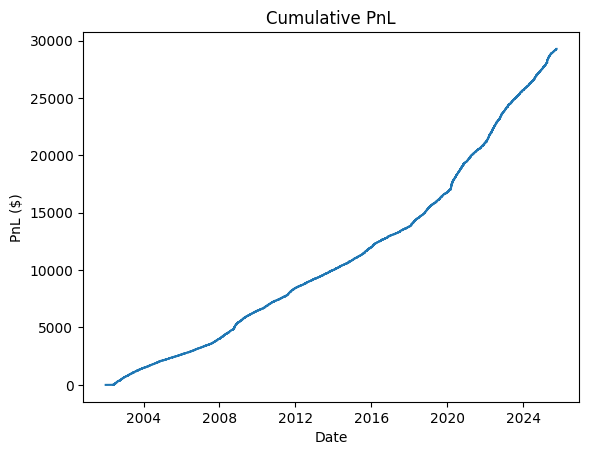

In [9]:
capital = 1000
df_ML["signal"] = (df_ML["pred_Open_h+1"] > df_ML["Open"]).astype(int)
df_ML["return_realized"] = (df_ML["Open"].shift(-1) - df_ML["Open"]) / df_ML["Open"]
df_ML["PnL"] = capital * df_ML["signal"] * df_ML["return_realized"]
df_ML["PnL_cum"] = df_ML["PnL"].cumsum()

print("Mean PnL:", df_ML["PnL"].mean())
print("Total PnL:", df_ML["PnL"].sum())

plt.plot(df_ML["Date"], df_ML["PnL_cum"])
plt.title("Cumulative PnL")
plt.xlabel("Date")
plt.ylabel("PnL ($)")
plt.show()

So a little word here\
At first sight it seems as a legit and profitable strategy\
However ! \
The mean PnL by trade is 0.0101 with a 1000$ invested \
That means a mere 0.001% of feas on each trade would kill our profitability \
We see on https://www.interactivebrokers.com/en/pricing/commissions-stocks.php that for very high volume (above 100 million per month of shares traded) the fee is USD 0.0005 by trafe so in some situation our strat is profitable

### XGboost

In [10]:
df_ML = df.copy()
df_ML = feature_engineering(df_ML)
df_ML = df_ML[df_ML["Date"] >= "01/01/2002"] #to get all the rollings ok

Here because of the cost of training of XGBoost\
We have to re-train the model every 12 hours to get an ok time of training about two hours\
Which for an intensive backtesting isn't that much tbh

In [11]:
from xgboost import XGBRegressor
from tqdm import tqdm
import pandas as pd

df_ML["Date"] = pd.to_datetime(df_ML["Date"])
sliding_window = 90 * 24
model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=42
)

total_iterations = len(df_ML) - sliding_window - 1
progress_bar = tqdm(total=total_iterations, desc="Training XGBoost models")
df_pred = pd.DataFrame(columns=["Date", "pred_Open_h+1"])
features = [col for col in df_ML.columns if col not in ["Open", "Date", "Time"]]

step = 12  # retrain every 12 hours

for start_point in range(0, total_iterations, step):
    start_idx = start_point
    end_idx = start_point + sliding_window

    df_sliding = df_ML.iloc[start_idx:end_idx]
    X = df_sliding[features]
    y = df_sliding["Open"].shift(-1).dropna()
    X = X.iloc[:-1]

    model.fit(X, y, verbose=False)

    #The prediction for the next 12hours
    for predict_idx in range(end_idx + 1, min(end_idx + 1 + step, len(df_ML))):
        X_next = df_ML[features].iloc[[predict_idx]]
        y_pred = model.predict(X_next)[0]
        pred_date = df_ML.iloc[predict_idx]["Date"]
        df_pred.loc[len(df_pred)] = [pred_date, y_pred]
        progress_bar.update(1)

progress_bar.close()
df_ML = df_ML.merge(df_pred, on="Date", how="left")

Training XGBoost models: 100%|██████████| 137411/137411 [1:37:06<00:00, 23.58it/s]  


Mean PnL: 0.008548184007042384
Total PnL: 24695.84891547357


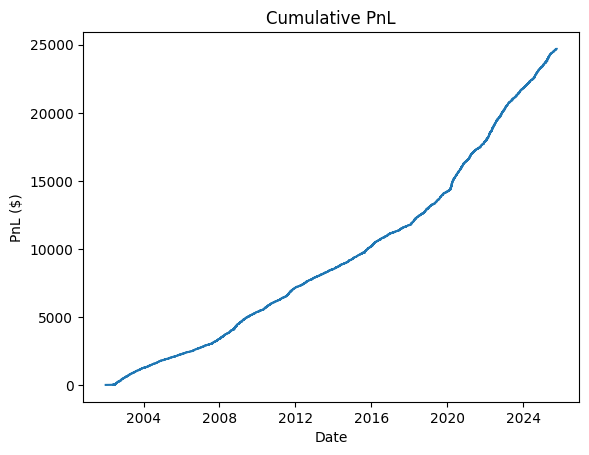

In [12]:
capital = 1000
df_ML["signal"] = (df_ML["pred_Open_h+1"] > df_ML["Open"]).astype(int)
df_ML["return_realized"] = (df_ML["Open"].shift(-1) - df_ML["Open"]) / df_ML["Open"]
df_ML["PnL"] = capital * df_ML["signal"] * df_ML["return_realized"]
df_ML["PnL_cum"] = df_ML["PnL"].cumsum()

print("Mean PnL:", df_ML["PnL"].mean())
print("Total PnL:", df_ML["PnL"].sum())

plt.plot(df_ML["Date"], df_ML["PnL_cum"])
plt.title("Cumulative PnL")
plt.xlabel("Date")
plt.ylabel("PnL ($)")
plt.show()

So very nice results the model seems to be more precise over the price\
This leads to two things
 - The PnL is Lower (WoW)
 - The profit per trade is lower 

Though the stragey is still profitable with the fees mentioned above so we increased drastically our PnL at the cost of some computing power\
As the cost of computing the fit very hour for the wole data set was 30 mins and for XGBosst it's 24 hours (so we trained it every 12 hours)\
I think we would be able to get a better performing strat if the model was re-trained every hour however the computing power and the timeframe doesn't allow this.\
Still in production it would be okay as the training would be (with a high number of CPU's) shor enough such that price wouldn' move much between the time at the open and the result of the forecast. 